In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seaborn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
help(nn.GRU)

Help on class GRU in module torch.nn.modules.rnn:

class GRU(RNNBase)
 |  GRU(*args, **kwargs)
 |  
 |  Applies a multi-layer gated recurrent unit (GRU) RNN to an input sequence.
 |  
 |  
 |  For each element in the input sequence, each layer computes the following
 |  function:
 |  
 |  .. math::
 |      \begin{array}{ll}
 |          r_t = \sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr}) \\
 |          z_t = \sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz}) \\
 |          n_t = \tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn})) \\
 |          h_t = (1 - z_t) * n_t + z_t * h_{(t-1)}
 |      \end{array}
 |  
 |  where :math:`h_t` is the hidden state at time `t`, :math:`x_t` is the input
 |  at time `t`, :math:`h_{(t-1)}` is the hidden state of the layer
 |  at time `t-1` or the initial hidden state at time `0`, and :math:`r_t`,
 |  :math:`z_t`, :math:`n_t` are the reset, update, and new gates, respectively.
 |  :math:`\sigma` is the sigmoid function, and :math:`

In [5]:
rnn = nn.GRU(10, 20, 2)
inputs = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
outputs, hn = rnn(inputs, h0)
outputs, hn

(tensor([[[ 2.3055e-01,  2.5716e-02,  4.5740e-01,  3.7781e-01,  7.8190e-02,
            1.8347e-01,  7.6843e-01, -2.5473e-01, -5.7000e-02, -2.6446e-02,
           -8.3580e-02,  1.2621e-01,  3.4657e-02, -4.9156e-01,  4.4637e-01,
            2.7897e-01, -5.4851e-02,  5.2738e-02, -4.7107e-01, -9.1475e-02],
          [-2.7087e-01,  7.4617e-01,  8.9711e-02,  2.8086e-01, -2.7391e-01,
           -2.5305e-01,  1.2640e+00, -7.5073e-02,  1.0244e+00, -2.2982e-01,
            1.4906e-01, -3.9038e-01,  8.8065e-01,  5.4107e-01, -4.1802e-02,
            4.5941e-01,  5.0731e-01, -8.6635e-02,  3.8593e-01, -6.1066e-01],
          [-2.1145e-01,  2.0153e-01, -1.7278e-01, -2.3729e-01,  1.0064e+00,
           -1.1166e-01,  6.5414e-01, -4.3845e-01,  1.5096e-01, -1.7989e-01,
            3.8273e-01,  2.4047e-02, -3.5726e-01, -1.8464e-01, -2.2593e+00,
           -5.6330e-01, -1.4881e+00,  8.3509e-01,  2.3473e-01, -4.8383e-01]],
 
         [[ 1.1466e-01,  3.7165e-03,  1.6816e-01,  7.6023e-02, -1.0573e-01,
      

In [13]:
# Here _get_weights corresponds to fatt, query is a decoder hidden state hi and values is a matrix of encoder hidden states s.
class Attention(torch.nn.Module):

    def __init__(self, encoder_dim: int, decoder_dim: int):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
    
    def forward(self, 
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor, # [seq_length, encoder_dim]
        ):
        weights = self._get_weights(query, values) # [seq_length] | not implemented
        weights = torch.nn.functional.softmax(weights, dim=0)
        return weights @ values  # [encoder_dim]

In [14]:
# Additive attention uses a single-layer feedforward neural network with hyperbolic tangent nonlinearity to compute the weights aij:
class AdditiveAttention(Attention):

    def __init__(self, encoder_dim, decoder_dim):
        super().__init__(encoder_dim, decoder_dim)
        self.v = torch.nn.Parameter(
            torch.FloatTensor(self.decoder_dim).uniform_(-0.1, 0.1))
        self.W_1 = torch.nn.Linear(self.decoder_dim, self.decoder_dim)
        self.W_2 = torch.nn.Linear(self.encoder_dim, self.decoder_dim)

    def _get_weights(self,        
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor,  # [seq_length, encoder_dim]
    ):
        query = query.repeat(values.size(0), 1)  # [seq_length, decoder_dim]
        weights = self.W_1(query) + self.W_2(values)  # [seq_length, decoder_dim]
        return torch.tanh(weights) @ self.v  # [seq_length]

In [93]:
attn = AdditiveAttention(encoder_dim=10, decoder_dim = 20)

In [94]:
# attn._get_weights(torch.randn(10), torch.randn(3, 20))
attn.W_1

Linear(in_features=20, out_features=20, bias=True)

In [95]:
attn

AdditiveAttention(
  (W_1): Linear(in_features=20, out_features=20, bias=True)
  (W_2): Linear(in_features=10, out_features=20, bias=True)
)

In [96]:
query = torch.randn(20) # [decoder dim]
values = torch.randn(10, 10) # [seq_length, encoder dim]

In [97]:
query2 = query.repeat(values.size(0), 1)

In [98]:
attn.W_1(query2).shape

torch.Size([10, 20])

In [99]:
attn.W_2(values).shape

torch.Size([10, 20])

In [100]:
v = torch.nn.Parameter(
            torch.FloatTensor(20).uniform_(-0.1, 0.1))

In [101]:
v.shape

torch.Size([20])

In [102]:
weights = attn.W_1(query2) + attn.W_2(values)

In [103]:
torch.tanh(weights) @ v # return seq_length

tensor([ 0.0325, -0.0951,  0.0298, -0.2375,  0.1206,  0.1327, -0.0260, -0.0677,
         0.0685, -0.1237], grad_fn=<MvBackward>)

In [91]:
class MultiplicativeAttention(Attention):

    def __init__(self, encoder_dim: int, decoder_dim: int):
        super().__init__(encoder_dim, decoder_dim)
        self.W = torch.nn.Parameter(torch.FloatTensor(
            self.decoder_dim, self.encoder_dim).uniform_(-0.1, 0.1))

    def _get_weights(self,
        query: torch.Tensor,  # [decoder_dim]
        values: torch.Tensor, # [seq_length, encoder_dim]
    ):
        weights = query @ self.W @ values.T  # [seq_length]
        return weights/np.sqrt(self.decoder_dim)  # [seq_length]

In [106]:
mattn = MultiplicativeAttention(encoder_dim=10, decoder_dim=20)

In [107]:
m_weights = query @ mattn.W @ values.T

In [112]:
m_weights

tensor([-0.3170,  0.1239, -1.0604, -1.0130, -0.2769, -0.7936,  1.5426, -0.8648,
        -0.7662,  0.2843], grad_fn=<SqueezeBackward3>)

In [113]:
m_weights/np.sqrt(20)

tensor([-0.0709,  0.0277, -0.2371, -0.2265, -0.0619, -0.1775,  0.3449, -0.1934,
        -0.1713,  0.0636], grad_fn=<DivBackward0>)

In [114]:
# In practice, the attention mechanism handles queries at each time step of text generation
attention = MultiplicativeAttention(encoder_dim=100, decoder_dim=50)
decoder = torch.nn.LSTMCell(100, 50)
encoder_hidden_states = torch.rand(10, 100)
h, c = torch.rand(1, 50), torch.rand(1, 50)
for step in range(13):
    context_vector = attention(h.squeeze(0), encoder_hidden_states)
    (h, c) = decoder(context_vector.unsqueeze(0), (h, c))
    # Generating the next work based on h

<AxesSubplot:>

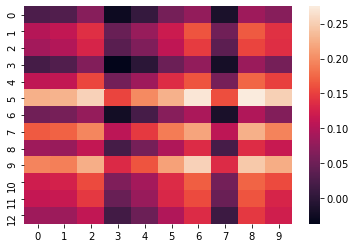

In [116]:
encoder_dim, decoder_dim, encoder_seq_length, decoder_seq_length = 100, 50, 10, 13
attention = AdditiveAttention(encoder_dim, decoder_dim)
encoder_hidden_states = torch.rand(encoder_seq_length, encoder_dim)
decoder_hidden_states = torch.rand(decoder_seq_length, decoder_dim)
weights = torch.FloatTensor(decoder_seq_length, encoder_seq_length)
for step in range(decoder_seq_length):
    context_vector = attention(decoder_hidden_states[step], encoder_hidden_states)
    weights[step] = attention._get_weights(decoder_hidden_states[step], encoder_hidden_states)
seaborn.heatmap(weights.detach().numpy())

In [132]:
help(torch.nn.BCEWithLogitsLoss)

Help on class BCEWithLogitsLoss in module torch.nn.modules.loss:

class BCEWithLogitsLoss(_Loss)
 |  BCEWithLogitsLoss(weight: Union[torch.Tensor, NoneType] = None, size_average=None, reduce=None, reduction: str = 'mean', pos_weight: Union[torch.Tensor, NoneType] = None) -> None
 |  
 |  This loss combines a `Sigmoid` layer and the `BCELoss` in one single
 |  class. This version is more numerically stable than using a plain `Sigmoid`
 |  followed by a `BCELoss` as, by combining the operations into one layer,
 |  we take advantage of the log-sum-exp trick for numerical stability.
 |  
 |  The unreduced (i.e. with :attr:`reduction` set to ``'none'``) loss can be described as:
 |  
 |  .. math::
 |      \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
 |      l_n = - w_n \left[ y_n \cdot \log \sigma(x_n)
 |      + (1 - y_n) \cdot \log (1 - \sigma(x_n)) \right],
 |  
 |  where :math:`N` is the batch size. If :attr:`reduction` is not ``'none'``
 |  (default ``'mean'``), then
 |  
 |  .. math:

In [133]:
help(torch.nn.BCELoss)

Help on class BCELoss in module torch.nn.modules.loss:

class BCELoss(_WeightedLoss)
 |  BCELoss(weight: Union[torch.Tensor, NoneType] = None, size_average=None, reduce=None, reduction: str = 'mean') -> None
 |  
 |  Creates a criterion that measures the Binary Cross Entropy
 |  between the target and the output:
 |  
 |  The unreduced (i.e. with :attr:`reduction` set to ``'none'``) loss can be described as:
 |  
 |  .. math::
 |      \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
 |      l_n = - w_n \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right],
 |  
 |  where :math:`N` is the batch size. If :attr:`reduction` is not ``'none'``
 |  (default ``'mean'``), then
 |  
 |  .. math::
 |      \ell(x, y) = \begin{cases}
 |          \operatorname{mean}(L), & \text{if reduction} = \text{'mean';}\\
 |          \operatorname{sum}(L),  & \text{if reduction} = \text{'sum'.}
 |      \end{cases}
 |  
 |  This is used for measuring the error of a reconstruction in for example
 |  an

In [134]:
help(nn.init.kaiming_uniform_)

Help on function kaiming_uniform_ in module torch.nn.init:

kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
    Fills the input `Tensor` with values according to the method
    described in `Delving deep into rectifiers: Surpassing human-level
    performance on ImageNet classification` - He, K. et al. (2015), using a
    uniform distribution. The resulting tensor will have values sampled from
    :math:`\mathcal{U}(-\text{bound}, \text{bound})` where
    
    .. math::
        \text{bound} = \text{gain} \times \sqrt{\frac{3}{\text{fan\_mode}}}
    
    Also known as He initialization.
    
    Args:
        tensor: an n-dimensional `torch.Tensor`
        a: the negative slope of the rectifier used after this layer (only
            used with ``'leaky_relu'``)
        mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
            preserves the magnitude of the variance of the weights in the
            forward pass. Choosing ``'fan_out'`

In [135]:
# Source: https://www.kaggle.com/mlwhiz/attention-pytorch-and-keras 
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

class Attention_Net(nn.Module):
    def __init__(self):
        super(Attention_Net, self).__init__()
        drp = 0.1
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False

        self.embedding_dropout = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(embed_size, 128, bidirectional=True, batch_first=True)
        self.lstm2 = nn.GRU(128*2, 64, bidirectional=True, batch_first=True)

        self.attention_layer = Attention(128, maxlen)
        
        self.linear = nn.Linear(64*2 , 64)
        self.relu = nn.ReLU()
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        h_lstm, _ = self.lstm2(h_lstm)
        h_lstm_atten = self.attention_layer(h_lstm)
        conc = self.relu(self.linear(h_lstm_atten))
        out = self.out(conc)
        return out